# Heat Waves
---

In the end of April 2025, Western European countries experienced unseasonably warm weather. This example shows analysis of the `2t` ([2 metre temperature](https://codes.ecmwf.int/grib/param-db/167)) parameter of the AIFS-Single datasets on 30 April at 12 UTC in France (48.3° N, 4.1° E). <br>
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.ipynb). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `earthkit`,
- `xarray`,
- `pandas`,
- `matplotlib`, and
- `cartopy`.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [14]:
# !pip3 install earthkit matplotlib cartopy
# !pip3 install xarray pandas

In [1]:
import xarray as xr
import pandas as pd
import earthkit.data as ekd
import earthkit.plots as ekp

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

To download the single `2t` parameter, we read the `_offset` and `_length` values from the corresponding index file.

In [59]:
index_file = ekd.from_source("s3",
                             {"endpoint": "s3.amazonaws.com",
                              "region": "eu-central-1",
                              "bucket": "ecmwf-forecasts",
                              "objects": "20250430/12z/aifs-single/0p25/oper/20250430120000-12h-oper-fc.index",
                             }, anon=True)
index_file = index_file.to_pandas()
value = index_file.iloc[[42]].to_string(index=False, header=False)
value

'{"domain": "g"  "date": "20250430"  "time": "1200"  "expver": "0001"  "class": "ai"  "type": "fc"  "stream": "oper"  "step": "12"  "levtype": "sfc"  "param": "2t"  "_offset": 34015908  "_length": 560208} NaN'

In [2]:
req = {"endpoint": "s3.amazonaws.com",
       "region": "eu-central-1",
       "bucket": "ecmwf-forecasts",
       "objects": { "object": "20250430/12z/aifs-single/0p25/oper/20250430120000-12h-oper-fc.grib2", "parts": (34015908, 560208)},
   }

data = ekd.from_source("s3", req, anon=True)
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20250430,1200,12,fc,None,regular_ll


:::{note}
The `parts` (byte ranges) can be specified when we want to retrieve data only for a specific parameter from the selected file. A type of a single part is list or tuple, i.e. (`_offset`, `_length`), where `_offset` is the start byte position and `_length` is the number of bytes to be read from the offset.
:::

:::{warning}
When we do not specify the `parts` option and want to convert our result to xarray.Dataset, we receive the following error message: <br>
ValueError: Variable "sot" has inconsistent dimension "levelist" compared to other variables. Expected values: (13) \[\[, 5, 0, ,,  , 1, 0, 0, ,,  , 1, 5, 0, ,,  , 2, 0, 0, ,,  , 2, 5, 0, ,,  , 3, 0, 0, ,,  , 4, 0, 0, ,,  , 5, 0, 0, ,,  , 6, 0, 0, \]..., 1000\], got: (2) \[1, 2\]. Length mismatch: 13 != 2
<br>
<br>
When we specify the `stream` option, the following error is thrown: <br>
NotImplementedError: earthkit.data.sources.stream.StreamFieldList.\__len\__()
:::

ECMWF data are on a \[0, 360\] grid. The code below bring the longitude coordinates to a \[-180, 180\] grid.

In [84]:
ds = data.to_xarray()
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
t2m = ds_180['2t']
t2m

<xarray.DataArray '2t' (latitude: 721, longitude: 1440)> Size: 8MB
[1038240 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Attributes:
    standard_name:  air_temperature
    long_name:      2 metre temperature
    units:          K
    _earthkit:      {'message': b'GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x0...

We will convert the 2 metre temperature from Kelvin to Celsius.

In [85]:
t2m_degc = t2m - 273.15
t2m_degc = t2m_degc.assign_attrs(t2m.attrs)
t2m_degc.attrs['units'] = '° C'
t2m_degc

<xarray.DataArray '2t' (latitude: 721, longitude: 1440)> Size: 8MB
array([[ -9.45223083,  -9.45223083,  -9.45223083, ...,  -9.45223083,
         -9.45223083,  -9.45223083],
       [ -9.45223083,  -9.45223083,  -9.45223083, ...,  -9.45223083,
         -9.45223083,  -9.45223083],
       [ -9.60848083,  -9.60848083,  -9.60848083, ...,  -9.60848083,
         -9.60848083,  -9.60848083],
       ...,
       [-41.95223083, -41.95223083, -41.95223083, ..., -41.98348083,
        -41.98348083, -41.98348083],
       [-41.35848083, -41.35848083, -41.35848083, ..., -41.38973083,
        -41.35848083, -41.35848083],
       [-41.04598083, -41.04598083, -41.04598083, ..., -41.04598083,
        -41.04598083, -41.04598083]], shape=(721, 1440))
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Attributes:
    standard_name:  air_temperature
    long_name:      2 metre temperature
    units:          ° C
    _earthkit:      {'message': b'GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x0...

We can plot our data using `earthkit.plots` library.

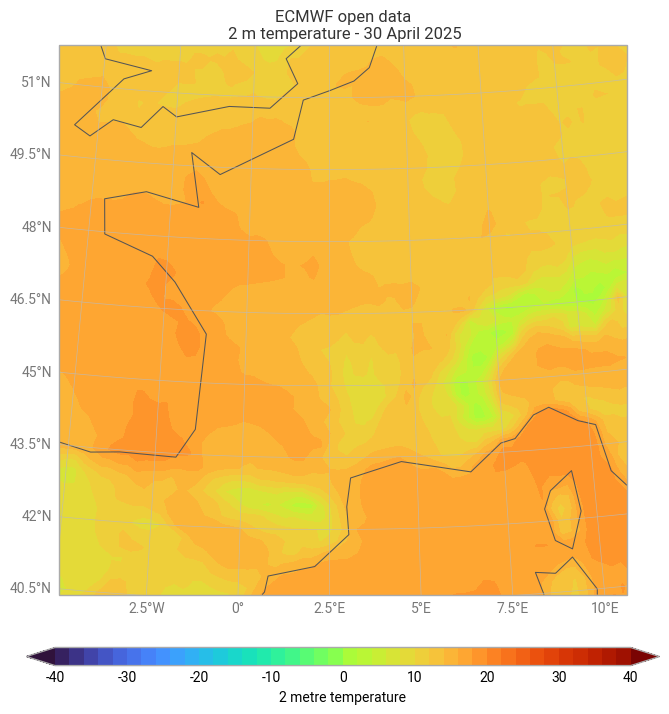

In [4]:
chart = ekp.Map(domain="France")

chart.quickplot(data, units="celsius")

chart.title("ECMWF open data\n 2 m temperature - 30 April 2025")

chart.coastlines(resolution="low")
chart.gridlines()

chart.legend(location="bottom", label="{variable_name}")

plt.savefig("t2m_aifs-single_20250430120000-12h.png")
chart.show()

_To be continued..._